In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import os
from sklearn import preprocessing
import seaborn as sns
from scipy.stats import pearsonr
import xarray

# functions

In [2]:
def get_path_holfuy(station, year, format=None):
    if year == 2021 and format=='csv_2021':
        folder = 'C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\holfuy\\2021\\final_readings_ablation\\'
        filename = str(station)+'_abl_sum.csv'
        path = os.path.join(folder, filename)
        return path
    elif year == 2019 and format=='csv_2021':
        folder = 'C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\holfuy\\2019\\'
        filename = str(station)+'_abl_sum_final.csv'
        path = os.path.join(folder, filename)
        return path
    elif year == 2020 and format=='csv_2021':
        folder = 'C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\holfuy\\2020\\'
        filename = str(station)+'_abl_sum_final.csv'
        path = os.path.join(folder, filename)
        return path

    elif format=='standard_point':
        folder = 'C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\holfuy\\2020\\holfuy_manual_readings_2020\\'
        if station==1001 or station==1008:
            filename = 'findelen_intermediate.dat'
        elif station==1002 or station==1006 or station==1007:
            filename = 'rhone_intermediate.dat'
        elif station==1003:
            filename = 'plainemorte_intermediate.dat'
            
        path = os.path.join(folder, filename)
        return path


def get_path_clim(station):
    if station == 1008:
        path = 'C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\climatology\\point_mb_Aaron\\cumulative_fin_200.dat'
    elif station == 1001:
        path = 'C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\climatology\\point_mb_Aaron\\cumulative_fin_700.dat'
    elif station == 1003:
        path = 'C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\climatology\\point_mb_Aaron\\cumulative_plm_P6.dat'
    elif station == 1007:
        path = 'C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\climatology\\point_mb_Aaron\\cumulative_rho_P5.dat'
    elif station == 1002:
        path = 'C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\climatology\\point_mb_Aaron\\cumulative_rho_P6.dat'
    elif station == 1006:
        path = 'C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\climatology\\point_mb_Aaron\\cumulative_rho_P8.dat'
    return path


def import_climatology(path):
    head = pd.read_csv(
        path, sep=';', skiprows=2, skipinitialspace=True,
        header=0, nrows=0, encoding='latin1').columns

    usecols = np.arange(len(head))
    colnames = head
    climatology = pd.read_csv(path,
                           skiprows=4, sep=' ', skipinitialspace=True,
                           usecols=usecols, header=None,
                           names=colnames, dtype={'date_s': str,
                                                  'date_f': str,
                                                  'date0': str,
                                                  'date1': str})
    climatology.columns = climatology.columns.str.rstrip()
    climatology.columns = climatology.columns.str.replace('# ', '')
    climatology = climatology.drop_duplicates()
    return climatology


def import_holfuy(fpath=None, station=None, year=None, ice_only=False, exclude_keywords=True, format=None):
    """

    Parameters
    ----------
    fpath
    ice_only
    exclude_keywords
    format: standard: original format from johannes

    Returns
    -------

    """
    if not fpath:
        fpath = get_path_holfuy(station, year, format)
    if format=='standard_csv':
        cread = pd.read_csv(fpath, index_col=None, parse_dates=[0])

        # exclude some of the critical days
        if exclude_keywords:
            cread = cread[~cread.key_remarks.str.contains("SETUP", na=False)]
            # cread = cread[~cread.key_remarks.str.contains("REDRILL", na=False)]
            cread = cread[~cread.key_remarks.str.contains("TEARDOWN", na=False)]

        if ice_only:
            cread = cread[cread.phase == 'i']  # exclude snow

        return cread

    elif format=='standard_point':
        head = pd.read_csv(
            fpath, sep=';', skiprows=1, skipinitialspace=True,
            header=0, nrows=0, encoding='latin1').columns
        usecols = np.arange(len(head))
        colnames = head
        df = pd.read_csv(fpath,
                         skiprows=4, sep=' ', skipinitialspace=True,
                         usecols=usecols, header=None,
                         names=colnames, dtype={'date0': str,
                                                'date1': str})
        df.columns = df.columns.str.rstrip()
        df.columns = df.columns.str.replace('# ', '')
        df = df.drop_duplicates()
        # manual remove error in the glazioarch files
        try:
            if df.loc[269]['name']=='HF1008':
                df = df.drop(index=269)
        except:
            pass

        if not station:
            df = df[df['name'].str.contains('|'.join('HF'))]
        else:
            df = df[df['name'].str.contains('HF'+str(station))]
        
        #print(df)
        selection = df[['date0', 'date1', 'mb_we']]

        date0 = [dt.datetime(int(x[0:4]), int(x[4:6]), int(x[6:])) for x in selection['date0'].values]
        date1 = [dt.datetime(int(x[0:4]), int(x[4:6]), int(x[6:])) for x in selection['date1'].values]
        selection = selection.assign(date0=date0)
        selection = selection.assign(date1=date1)
        selection = selection[['date0', 'date1', 'mb_we']]
        if year is not None:
            selection = selection[selection['date0'].dt.year == year]
        return selection

    elif format=='csv_2021':
        cread = pd.read_csv(fpath, index_col=None, parse_dates=[0], dayfirst=True)
        return cread
    elif format=='winter':
        cread = pd.read_excel(fpath, index_col=None)#, parse_dates=[0], dayfirst=True)
        return cread
    elif format=='mh_2021':
        #path_mh = 'C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\holfuy\\2021\\holfuy_manual_readings_2021\\matthias\\fin1001_p700_holfuy2021.xlsx'
        holfuy_mh = pd.read_excel(fpath, index_col=None, skiprows=8, usecols=[0, 6], names=['date', 'mb[m.w.e]'])
        holfuy_mh = holfuy_mh.loc[holfuy_mh['date'].notnull()]
        holfuy_mh['mb[m.w.e]'] = holfuy_mh['mb[m.w.e]']/100
        return holfuy_mh
    else:
        return None
    
    
def interpolate_holfuy_df(df, mode=None):
    if mode is not None:
        time = np.arange(df['date'].values[0], df['date'].values[-1])
    else:
        time = np.arange(df['date'].values[0], df['date'].values[-1], dt.timedelta(days=1))
    not_yet_interpolated_holfuy = []
    for t in time:
        if t in df['date'].values:
            not_yet_interpolated_holfuy.append(df[df['date'] == t]['mb[m.w.e]'].values[0])
        else:
            not_yet_interpolated_holfuy.append(np.nan)

    interpolated_df = pd.DataFrame({'date': time, 'mb[m.w.e]': not_yet_interpolated_holfuy})
    if interpolated_df['mb[m.w.e]'].isnull().values.any():
        interpolated_df['mb[m.w.e]'] = interpolated_df['mb[m.w.e]'].interpolate(axis=0)
    return interpolated_df    


def get_mb_beg_year_to_holfuy_period(df, station, year):
    if year == 2021:
        return 0
    else:
        path = 'C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\holfuy\\mb_begin_holfuy_period.xlsx'
        mb_begin_df = pd.read_excel(path)
        indexes = mb_begin_df[(mb_begin_df['station']!=station) | (mb_begin_df['date'].dt.year!=year)].index
        # droping mutiple rows based on column value
        mb_begin_df = mb_begin_df.drop(indexes)
        date = mb_begin_df['date'].values[0]
        mb = mb_begin_df['mb[m.w.e]'].values[0]
        #print(date, mb)
        shift = mb - df[df['date']==date]['mb[m.w.e]'].values[0]
        return shift

    
def get_date_last_meas(station, year):
    path = 'C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\holfuy\\mb_begin_holfuy_period.xlsx'
    mb_begin_df = pd.read_excel(path)
    indexes = mb_begin_df[(mb_begin_df['station']!=station) | (mb_begin_df['date'].dt.year!=year)].index
    # droping mutiple rows based on column value
    mb_begin_df = mb_begin_df.drop(indexes)
    date = mb_begin_df['date_meas'].values[0]
    return date


def get_mb_last_meas_to_end(station, date):
    clim = import_climatology(get_path_clim(station))
    date = date.astype('datetime64[s]')
    date = date.astype(dt.datetime)
    clim = clim[clim['Hyd.year'] == date.year]
    mb_3009 = clim['balance(b)'].values[-1]
    clim = clim[clim['Month'] == date.month]
    clim = clim[clim['Day'] == date.day]
    mb_measure_day = clim['balance(b)'].values[0]

    mb_last_measure_to_end  = mb_3009 - mb_measure_day
    #print(mb_last_measure_to_end)
    return mb_last_measure_to_end

    
def cut_clim_to_holfuy_period(clim_df, holfuy_df):
    first_date = np.min(holfuy_df['date'])
    last_date = np.max(holfuy_df['date'])
    indexes = clim_df[(clim_df['year'] < first_date.year)
                        | (clim_df['Month'] < first_date.month)
                        | (clim_df['Month'] == first_date.month) & (clim_df['Day'] < first_date.day)
                        | (clim_df['Month'] > last_date.month)
                        | (clim_df['Month'] == last_date.month) & (clim_df['Day'] > last_date.day)].index
    # droping mutiple rows based on column value
    clim_df = clim_df.drop(indexes)
    holfuy_df = holfuy_df[holfuy_df['date']<=dt.datetime(year=first_date.year, month=9, day=30)]
        
    return clim_df, holfuy_df


def get_bias(station, year, visualize=True):
    # holfuy
    #if year == 2021:
    holfuy = import_holfuy(station=station, year=year, format='csv_2021')
    xtime_h = holfuy['date'].values
    rounded = xtime_h.astype('datetime64[s]')
    xtime_h = [x.astype(dt.datetime) for x in rounded]
    cum_mb = holfuy['mb[m.w.e]'].values
    holfuy_new = pd.DataFrame({'date': xtime_h, 'mb[m.w.e]': cum_mb})
    #else:
    #    holfuy = import_holfuy(station=station, year=year, format='csv_2021')
    #    xtime_h = holfuy['date1'].values
    #    cum_mb = np.cumsum(holfuy['mb_we'].values / 1000)
    #    holfuy_new = pd.DataFrame({'date': xtime_h, 'mb[m.w.e]': cum_mb})
    # clim
    xtime_c = pd.date_range(dt.datetime(year - 1, 10, 1), periods=366)
    if ((xtime_c.month == 2) & (xtime_c.day == 29)).any():
        pass
    else:
        xtime_c = xtime_c[:-1]

    clim = import_climatology(get_path_clim(station))
    clim = clim[clim['Hyd.year'] == year]
    
    #if year != 2019:
    #    date_last_measure = get_date_last_meas(station, year)
    #    mb_last_measure_to_end = get_mb_last_meas_to_end(station, date_last_measure)
    #    clim['balance(b)'] = clim['balance(b)'].values + mb_last_measure_to_end
    
    # interpolate holfuy data to have values every day
    interpolated_df = interpolate_holfuy_df(holfuy_new)
    print(interpolated_df)
    #if year != 2019:
    #mb_begin_season = get_mb_beg_year_to_holfuy_period(interpolated_df, station, year)
    #interpolated_df['mb[m.w.e]'] = interpolated_df['mb[m.w.e]'].values + mb_begin_season
    
    # cut clim to match the length of holfuy data
    clim_cutted, interpolated_df = cut_clim_to_holfuy_period(clim, interpolated_df)

    interpolated_df['mb[m.w.e]'] = interpolated_df['mb[m.w.e]'].values + \
                                    ((clim_cutted['balance(b)'].values[0] / 1000) - interpolated_df['mb[m.w.e]'].values[0])
    
    clim_corr, delta_grad = correct_slope_bias(clim_cutted, interpolated_df)
    
    bias_y = interpolated_df['mb[m.w.e]'].values - clim_corr['balance(b)'].values / 1000
    
    mean_bias_y = np.nanmean(bias_y)
    name, color = station_name(station)
    
    if visualize:
        fig, ax = plt.subplots(figsize=(10, 7))        
        #fig.text(0.25, 0.13, 'mean bias: ' + str(round(mean_bias_y, 3)) + ' m.w.e')
        ax.plot(interpolated_df['date'].values, interpolated_df['mb[m.w.e]'].values, label='observed', marker='.', markersize=6, markerfacecolor='black', markeredgecolor='black', color='tab:blue', linewidth=2.5)
        #ax.scatter(interpolated_df['date'], interpolated_df['mb[m.w.e]'], marker='x', color='black', s=10)
        ax.plot(interpolated_df['date'].values, clim_corr['balance(b)'].values / 1000, label='modelled', color='tab:red', linewidth=2.5)
        #ax.plot(interpolated_df['date'].values, clim_cutted['balance(b)'].values / 1000, label='model raw', color='tab:red')
        #ax.plot(interpolated_df['date'].values, bias_y, label='bias', color='tab:red')
        #ax.fill_between(interpolated_df['date'].values, bias_y, alpha=0.3, color='tab:red')
        #plt.title(name + ' year: ' + str(year))
        #plt.suptitle('MODEL VS HOLFUY', fontweight="bold")
        #plt.xlabel('Time')
        plt.ylabel('Mass Balance [m.w.e]', fontsize=16)
        plt.legend(fontsize=16)
        plt.xticks(fontsize = 12)
        plt.yticks(fontsize = 16)
        plt.grid(True, axis='y', linestyle='--')

        #plt.savefig('C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\writing\\glacier_anomalies\\pictures\\bias.png', transparent=False)
        plt.show()
    return clim_corr, interpolated_df, mean_bias_y, delta_grad


def get_bias_clim(station, year, visualize=True, mean_slope_bias=None, d0=None, d1=None):
    #if year == 2021:
    holfuy = import_holfuy(station=station, year=year, format='csv_2021')
    xtime_h = holfuy['date'].values
    rounded = xtime_h.astype('datetime64[s]')
    xtime_h = [x.astype(dt.datetime) for x in rounded]
    xtime_doy = [x.timetuple().tm_yday for x in xtime_h]  #
    cum_mb = holfuy['mb[m.w.e]'].values
    holfuy_new = pd.DataFrame({'date': xtime_doy, 'mb[m.w.e]': cum_mb})
    #else:
    #    holfuy = import_holfuy(station=station, year=year, format='csv_2021')
    #    xtime_h = holfuy['date1'].values
    #    rounded = xtime_h.astype('datetime64[s]')  #
    #    xtime_h = [x.astype(dt.datetime) for x in rounded]  #
    #    xtime_doy = [x.timetuple().tm_yday for x in xtime_h]  #
    #    cum_mb = np.cumsum(holfuy['mb_we'].values / 1000)
    #    holfuy_new = pd.DataFrame({'date': xtime_doy, 'mb[m.w.e]': cum_mb})
    # clim
    xtime_c = pd.date_range(dt.datetime(year - 1, 10, 1), periods=366)
    if ((xtime_c.month == 2) & (xtime_c.day == 29)).any():
        pass
    else:
        xtime_c = xtime_c[:-1]

    clim = import_climatology(get_path_clim(station))
    
    clim_std = clim.groupby(['DOY']).std().reset_index()  #
    clim = clim.groupby(['DOY']).mean().reset_index()  #
    interpolated_df = interpolate_holfuy_df(holfuy_new, mode='DOY')  #
    
    if year==2019 and station==1002:
        n = 2
        clim = clim.iloc[:-n]
        interpolated_df = interpolated_df.iloc[:-n]
    elif year==2019 and station==1006:
        n = 2
        clim = clim.iloc[:-n]
        interpolated_df = interpolated_df.iloc[:-n]
    elif year==2019 and station==1007:
        n = 1
        clim = clim.iloc[:-n]
        interpolated_df = interpolated_df.iloc[:-n]
    else:
        pass

    first_date = np.min(interpolated_df['date'])
    last_date = np.max(interpolated_df['date'])
    
    if d0 is not None and d0 >= first_date:
        first_date = d0 
    if d1 is not None and d1<= last_date:
        last_date = d1
            
    indexes = clim[(clim['DOY'] < first_date) | (clim['DOY'] > last_date)].index  #
    indexes_h = interpolated_df[(interpolated_df['date'] < first_date) | (interpolated_df['date'] > last_date)].index

    # droping mutiple rows based on column value
    clim_cutted = clim.drop(indexes)
    clim_std_cutted = clim_std.drop(indexes)
    interpolated_df = interpolated_df.drop(indexes_h)
    
    interpolated_df['mb[m.w.e]'] = interpolated_df['mb[m.w.e]'].values + \
                                    ((clim_cutted['balance(b)'].values[0] / 1000) - interpolated_df['mb[m.w.e]'].values[0])
 
    clim_corr = clim_cutted.copy()
    if mean_slope_bias is not None:
        clim_corr['balance(b)'] = clim_corr['balance(b)'].values + mean_slope_bias*1000*np.arange(len(clim_corr['balance(b)'].values))
    

    
    interpolated_df['rate'] = interpolated_df['mb[m.w.e]'] - interpolated_df['mb[m.w.e]'].shift(1)
    interpolated_df = interpolated_df.dropna()
    clim_corr['rate_b'] = clim_corr['balance(b)'] - clim_corr['balance(b)'].shift(1)
    clim_corr = clim_corr.dropna()
    #print(interpolated_df, clim_corr)
    
    bias_y = interpolated_df['mb[m.w.e]'].values - clim_corr['balance(b)'].values / 1000
    bias_rate = interpolated_df['rate'].values - clim_corr['rate_b'].values / 1000
    bias_perc = bias_rate/(clim_corr['rate_b'].values / 1000)
    #print(interpolated_df['date'].values)
    name, color = station_name(station)
    
    dates_for_plot = doy_to_date(clim_corr['DOY'].values, year)
    
    if visualize:
        if bias_only:
            if plot_rate:
                if do_smooth:
                    ax1.plot(clim_corr['DOY'].values, smooth(bias_rate,3),
                             label=name, marker='.', color=color, markerfacecolor='black', markeredgecolor='black')
                else:
                    ax1.plot(clim_corr['DOY'].values, bias_rate,
                             label=name, color=color, marker='.', markerfacecolor=color, markeredgecolor=color, markersize=5)
                    #ax1.set_xticks(clim_corr['DOY'].values, labels=np.arange(dt.datetime(year,6,19), dt.datetime(year,9,22), dt.timedelta(days=1)))
                    
                    #ax1.fill_between(clim_corr['DOY'].values, np.ones(len(bias_rate))*-0.03, bias_rate, 
                    #                 where = bias_rate <= np.ones(len(bias_rate))*-0.03, color=color, alpha=0.2, interpolate=True)
                    #ax1.fill_between(clim_corr['DOY'].values, np.ones(len(bias_rate))*0.03, bias_rate, 
                    #                 where = bias_rate >= np.ones(len(bias_rate))*0.03, color=color, alpha=0.2, interpolate=True)
            else:
                ax1.plot(clim_corr['DOY'].values, np.cumsum(bias_rate),
                         label=name, color=color)
                ax1.fill_between(clim_corr['DOY'].values, np.cumsum(bias_rate), color=color, alpha=0.05)
        else:
            if plot_rate:
                fig, ax = plt.subplots(figsize=(10, 7))
                ax.plot(interpolated_df['date'].values, interpolated_df['rate'].values, label='holfuy', color='tab:blue')
                ax.scatter(interpolated_df['date'].values, interpolated_df['rate'].values, marker='x', color='black', s=10)
            
                #ax.plot(clim_cutted['DOY'].values, clim_cutted['balance(b)'].values / 1000, label='climatology', color='tab:red')
                ax.plot(clim_corr['DOY'].values, clim_corr['rate_b'].values / 1000, label='climatology', color='tab:green')
                #ax.fill_between(clim_corr['DOY'].values, (clim_corr['rate_b'].values - clim_std_cutted['balance(b)'].values[1:])/ 1000 ,
                #                (clim_corr['balance(b)'].values + clim_std_cutted['balance(b)'].values[1:])/ 1000 , color='tab:green', alpha=0.1)
            
                ax.plot(clim_corr['DOY'].values, bias_rate, label='bias' + 'Station : ' + str(station)+ ' year : ' + str(year), color='tab:red')
                ax.fill_between(clim_corr['DOY'].values, bias_rate, color='tab:red', alpha=0.2)
                #ax.plot(clim_cutted['DOY'].values, np.cumsum(bias_y), label=' cum. bias' + 'Station : ' + str(station)+ ' year : ' + str(year), color='tab:green')
                #ax.fill_between(clim_cutted['DOY'].values, np.cumsum(bias_y), color='tab:green', alpha=0.2)

                plt.title('year ' + str(year) + ', station ' + str(station))
                plt.suptitle('CLIMATOLOGY VS HOLFUY', fontweight="bold")
                plt.xlabel('Day of Year')
                plt.ylabel('Mass Balance Rate [m.w.e d -1]')
                plt.legend()
                plt.show()
            else:
                fig, ax = plt.subplots(figsize=(10, 7))
                ax.plot(interpolated_df['date'].values, interpolated_df['mb[m.w.e]'].values, label='holfuy', color='tab:blue')
                ax.scatter(interpolated_df['date'].values, interpolated_df['mb[m.w.e]'].values, marker='x', color='black', s=10)
            
                #ax.plot(clim_cutted['DOY'].values, clim_cutted['balance(b)'].values / 1000, label='climatology', color='tab:red')
                ax.plot(clim_corr['DOY'].values, clim_corr['balance(b)'].values / 1000, label='climatology', color='tab:green')
                ax.fill_between(clim_corr['DOY'].values, (clim_corr['balance(b)'].values - clim_std_cutted['balance(b)'].values[1:])/ 1000 ,
                                (clim_corr['balance(b)'].values + clim_std_cutted['balance(b)'].values[1:])/ 1000 , color='tab:green', alpha=0.1)
            
                ax.plot(clim_corr['DOY'].values, bias_y, label='bias' + 'Station : ' + str(station)+ ' year : ' + str(year), color='tab:green')
                ax.fill_between(clim_corr['DOY'].values, bias_y, color='tab:green', alpha=0.2)
                #ax.plot(clim_cutted['DOY'].values, np.cumsum(bias_y), label=' cum. bias' + 'Station : ' + str(station)+ ' year : ' + str(year), color='tab:green')
                #ax.fill_between(clim_cutted['DOY'].values, np.cumsum(bias_y), color='tab:green', alpha=0.2)

                plt.title('year ' + str(year) + ', station ' + str(station))
                plt.suptitle('CLIMATOLOGY VS HOLFUY', fontweight="bold")
                plt.xlabel('Day of Year')
                plt.ylabel('Mass Balance [m.w.e]')
                plt.legend()
                plt.show()
    #print(bias_rate)
    return clim_corr['DOY'].values, bias_rate


def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth
            

def correct_slope_bias(clim_df, holfuy_df):
    mb_grad_clim = (clim_df['balance(b)'].iloc[-1] - clim_df['balance(b)'].iloc[0])/(1000*len(clim_df['balance(b)'].values))
    mb_grad_holfuy = (holfuy_df['mb[m.w.e]'].iloc[-1] - holfuy_df['mb[m.w.e]'].iloc[0])/len(holfuy_df['mb[m.w.e]'].values)
    delta_grad = mb_grad_holfuy - mb_grad_clim
    print('bias slope: ', delta_grad)
    clim_corr = clim_df.copy()
    clim_corr['balance(b)'] = clim_corr['balance(b)'].values + delta_grad*1000*np.arange(len(clim_corr['balance(b)'].values))
    return clim_corr, delta_grad

def station_name(station):
    if station == 1001:
        name = 'FIN2'
        color = 'darkred'
    if station == 1008:
        name = 'FIN1'
        color = 'salmon'
    if station == 1003:
        name = 'PLM'
        color = 'gold'
    if station == 1002:
        name = 'RHO1'
        color = 'lightskyblue'
    if station == 1006:
        name = 'RHO2'
        color = 'royalblue'
    if station == 1007:
        name = 'RHO3'
        color = 'darkblue'
    return name, color


def interpolate_manual_df(df, mode=None):
    key = 'date0'
    time = np.arange(df[key].values[0], df[key].values[-1], dt.timedelta(days=1))
    not_yet_interpolated_holfuy = []
    for t in time:
        if t in df[key].values:
            not_yet_interpolated_holfuy.append(df[df[key] == t]['mb_we'].values[0])
        else:
            not_yet_interpolated_holfuy.append(0)

    interpolated_df = pd.DataFrame({'date': time, 'mb[m.w.e]': not_yet_interpolated_holfuy})
    return interpolated_df


def doy_to_date(doy_array, year):
    date_array = []
    for doy in doy_array:
        date_array.append(dt.datetime.strptime(str(year) + "-" + str(doy), "%Y-%j").strftime("%m-%d-%Y"))
    return date_array

# Main 1
    . get vertical bias between model and modelled year
    . plot bias between climatology and holfuy
    . compares all biases

In [ ]:
bias_only= False
years = [2020]
# attention order of the paths resp stations must agre!!!
#paths = [path_climf2]#, path_climf7, path_climr5, path_climr6, path_climr8, path_climp6]
stations = [1001]#, 1001, 1007, 1002, 1006, 1003]
bias = []

if bias_only:
    fig1, ax1 = plt.subplots(figsize=(10, 7))

for station in stations:
    for year in years:
        if bias_only:
            get_bias_clim(station, year)
        else:
            #get_bias_clim(station, year)
            bias_y = get_bias(station, year, visualize=True)
            bias.append(bias_y)
    print(bias, np.mean(bias))
if bias_only:
    plt.xlabel('Day of Year')
    plt.ylabel('Mass Balance [m.w.e]')
    plt.legend()
    plt.show()

# Main 2

In [ ]:
# getting the bias

global fig1, ax1, plot_rate

bias_only= True

years = [2019, 2020, 2021]
stations = [1001, 1008, 1003, 1007, 1006, 1002]
    
slope_bias = []
station_bias = []
for station in stations:
    for year in years:
        clim_cutted, interpolated_df, mean_bias_y, delta_grad = get_bias(station, year, visualize=True)
        slope_bias.append(delta_grad)
    mean_slope_bias = np.nanmean(slope_bias)
    print(mean_slope_bias) 
    station_bias.append(mean_slope_bias)
bias_df = pd.DataFrame({'station': stations, 'slope_bias': station_bias})
print(bias_df)


In [ ]:
plot_rate = True
bias_only = True
years = [2021]
d00 = 210
d10 = 230
names = ['FIN top', 'FIN bot.', 'PLM', 'RHO top', 'RHO mid.', 'RHO bot.']
stations = [1001, 1008, 1003, 1007, 1006, 1002]

for i in range(4):
    d0 = d00 + i*10
    d1 = d10 + i*10
    df_biases = pd.DataFrame()

    for year in years:
        if bias_only:
            fig1, ax1 = plt.subplots(figsize=(10, 7))    
        for station in stations:
            bias_station = bias_df[bias_df['station'] == station]['slope_bias'].values[0]
            #print(bias_station)
            bias_rate = get_bias_clim(station, year, mean_slope_bias=bias_station, d0=d0, d1=d1)
            name, color = station_name(station)
            df_temp = pd.DataFrame({name: bias_rate}) 
            #print(df_temp)
            df_biases = pd.concat([df_biases, df_temp], axis=1)
            
            #plt.hist(bias_rate)
            #plt.show()
            
        if bias_only:
            plt.xlabel('Day of Year')
            if plot_rate:
                plt.ylabel('Diff. Holfuy - Clim. [m.w.e/d]')
            else:
                plt.ylabel('Diff. Holfuy - Clim. [m.w.e]')
            plt.title('Year: ' + str(year))
            plt.fill_between(np.arange(d0-2,d1+2), 0, -0.01, alpha=0.1, color='tab:green')
            plt.fill_between(np.arange(d0-2,d1+2), 0, 0.01, alpha=0.1, color='tab:green')
            plt.fill_between(np.arange(d0-2,d1+2), -0.01, -0.02, alpha=0.1, color='yellow')
            plt.fill_between(np.arange(d0-2,d1+2), 0.01, 0.02, alpha=0.1, color='yellow')
            plt.fill_between(np.arange(d0-2,d1+2), -0.02, -0.03, alpha=0.1, color='orange')
            plt.fill_between(np.arange(d0-2,d1+2), 0.02, 0.03, alpha=0.1, color='orange')
            plt.fill_between(np.arange(d0-2,d1+2), -0.03, -0.06, alpha=0.1, color='tab:red')
            plt.fill_between(np.arange(d0-2,d1+2), 0.03, 0.06, alpha=0.1, color='tab:red')
            plt.grid(True, axis='y', linestyle='--')
            plt.legend()
            plt.show()
        
#for i, name in enumerate(names):
#    fig, ax = plt.subplots(figsize=(10, 7)) 
#    sns.regplot(x=df_biases[names[i]], y=df_biases[names[i+1]])
#    try:
#        (r, p) = pearsonr(df_biases[names[i]].dropna(), df_biases[names[i+1]].dropna())
#        fig.text(0.25, 0.13, r)
#    except:
#        pass
#    plt.show()
#    if i==len(names)-2:
#        break
        
    corr = df_biases.corr()
    mask_ut=np.tril(np.ones((corr.shape))).astype(bool)
    sns.heatmap(corr, mask=~mask_ut, cmap='Greens', vmin=0, annot=True)

In [ ]:
plot_rate = False
bias_only = True
years = [2019]
d0 = 228 -20
d1 = 258 -20

df_biases = pd.DataFrame()

for year in years:
    if bias_only:
        fig1, ax1 = plt.subplots(figsize=(10, 7))    
    for station in stations:
        bias_station = bias_df[bias_df['station'] == station]['slope_bias'].values[0]
        #print(bias_station)
        bias_rate = get_bias_clim(station, year, mean_slope_bias=bias_station, d0=d0, d1=d1)
        name, color = station_name(station)
        df_temp = pd.DataFrame({name: bias_rate}) 
        #print(df_temp)
        df_biases = pd.concat([df_biases, df_temp], axis=1)
    
    if bias_only:
        plt.xlabel('Day of Year')
        if plot_rate:
            plt.ylabel('Diff. Holfuy - Clim. [m.w.e/d]')
        else:
            plt.ylabel('Diff. Holfuy - Clim. [m.w.e]')
        plt.title('Year: ' + str(year))
        plt.grid(True, axis='y', linestyle='--')
        plt.legend()
        plt.show()
        
names = ['FIN top', 'FIN bot.', 'PLM', 'RHO top', 'RHO mid.', 'RHO bot.']
#for i, name in enumerate(names):
    #fig, ax = plt.subplots(figsize=(10, 7)) 
    #sns.regplot(x=df_biases[names[i]], y=df_biases[names[i+1]])
    #try:
    #    (r, p) = pearsonr(df_biases[names[i]].dropna(), df_biases[names[i+1]].dropna())
    #    fig.text(0.25, 0.13, r)
    #except:
    #    pass
    #plt.show()
    #if i==len(names)-2:
    #    break
        
corr = df_biases.corr()
mask_ut=np.tril(np.ones((corr.shape))).astype(bool)
sns.heatmap(corr, mask=~mask_ut, cmap='Greens', vmin=0., annot=True)

In [ ]:
#qui
plot_rate = True
bias_only = True
do_smooth = False

years = [2020]#, 2020, 2021]
d0 = 210 - 40
d1 = 265 #+10

df_biases = pd.DataFrame(index=np.arange(d0,d1,1))

for year in years:
    if bias_only:
        fig1, ax1 = plt.subplots(figsize=(15, 6))    
    for station in stations:
        bias_station = bias_df[bias_df['station'] == station]['slope_bias'].values[0]
        #print(bias_station)
        doys, bias_rate = get_bias_clim(station, year, mean_slope_bias=bias_station, d0=d0, d1=d1)
        #print(doys, len(bias_rate))
        name, color = station_name(station)
        
        if do_smooth:
            df_temp = pd.DataFrame({name: bias_rate.rolling(2).sum()})
            #df_temp = df_temp.set_index('doy')
        else:
            df_temp = pd.DataFrame({'doy': doys, name: bias_rate})
            df_temp = df_temp.set_index('doy')
            #df_temp = df_temp.rolling(5).sum()
        #print(df_temp)
        df_biases = pd.concat([df_biases, df_temp], axis=1)
    
    if bias_only:
        #plt.xlabel('Day of Year')
        if plot_rate:
            pass
            #
        else:
            plt.ylabel('Diff. Holfuy - Clim. [m.w.e]')
            
        plt.plot(np.arange(d0,d1+1,1), df_biases.mean(axis=1), label='mean', linewidth=3, color='red',
                marker='.', markerfacecolor='black', markeredgecolor='black')
            
        plt.plot([d0-2,d1+2],[0,0],color='black')
        plt.plot([d0-2,d1+2],[0.025,0.025],color='black', linewidth=1)
        plt.plot([d0-2,d1+2],[-0.025, -0.025],color='black', linewidth=1)
        #plt.title('Year: ' + str(year))
        plt.grid(True, axis='y', linestyle='--')
        ax1.set_xlim([170, 267])
        ax1.set_ylim([-0.09, 0.065])
        print(ax1.get_xticks())
        
        xtime_h = np.arange(dt.datetime(year,6,19), dt.datetime(year,9,17), dt.timedelta(days=20))
        rounded = xtime_h.astype('datetime64[D]')        
        ax1.set_xticks(np.arange(180, 280, 20), labels=rounded)
        
        #for a in ax1.flatten():
        ax1.tick_params(axis='both', which='major', labelsize=14)
        plt.ylabel('Mass balance anomaly [m.w.e/d]', fontsize=17)
        plt.legend(loc='upper left', fontsize=13)
        #plt.savefig('C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\writing\\glacier_anomalies\\pictures\\anomalies_2021_auto.png')
        plt.show()
        
        df_mean = pd.DataFrame({'mean': df_biases.mean(axis=1)})
        df_biases = pd.concat([df_biases, df_mean], axis=1)
        #df_biases = df_biases.rename(columns = {0: 'mean'}, inplace = True)
        
names = ['FIN2', 'FIN1', 'PLM', 'RHO3', 'RHO2', 'RHO1']
#for i, name in enumerate(names):
#    fig, ax = plt.subplots(figsize=(10, 7)) 
#    sns.regplot(x=df_biases[names[i]], y=df_biases[names[i+1]])
#   try:
#        (r, p) = pearsonr(df_biases[names[i]].dropna(), df_biases[names[i+1]].dropna())
#        fig.text(0.25, 0.13, r)
#    except:
#        pass
#    plt.show()
#    if i==len(names)-2:
#        break
        
corr = df_biases.corr()
mask_ut=np.tril(np.ones((corr.shape))).astype(bool)

annot_kws={'fontsize':13}

#swarm_plot = sns.heatmap(corr, mask=~mask_ut, cmap='Greens', vmin=0., annot=True, annot_kws= annot_kws)
#swarm_plot.figure.axes[-1].yaxis.label.set_size(18)
#sns.set(font_scale=0.8)
#fig = swarm_plot.get_figure()
#fig.savefig('C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\writing\\glacier_anomalies\\pictures\\corr_matrix_2021_wmean.png') 
#plt.show()

ds_corr = corr.to_xarray()

# AGGREGATION
step = [3, 5, 7, 9, 11]

for ste in step: 
    print(ste)
    df_aggregated = pd.DataFrame()
    for i in df_biases.index:
        df_biases_copy = df_biases.copy()
        #if i<=171:
        #    pass
        if i%ste!=0:
            pass
        else:   
            indexes_2drop = df_biases_copy[(df_biases_copy.index<i-((ste-1)/2)) | (df_biases_copy.index>i+((ste-1)/2))].index
            df_biases_copy = df_biases_copy.drop(indexes_2drop)
            df_biases_copy = df_biases_copy.sum(axis=0).to_frame().T
            df_aggregated = pd.concat([df_aggregated, df_biases_copy], axis=0)
    df_aggregated = df_aggregated.reset_index()

    df_aggregated = df_aggregated.drop('index', axis=1)
    df_aggregated = df_aggregated.replace(0.0, np.nan)

    corr = df_aggregated.corr()
    #print(corr)
    ds_corr = xarray.concat([ds_corr, corr.to_xarray()], dim='aggregation')
    
    mask_ut=np.tril(np.ones((corr.shape))).astype(bool)

    annot_kws={'fontsize':13}

    #swarm_plot = sns.heatmap(corr, mask=~mask_ut, cmap='Greens', vmin=0., annot=True, annot_kws= annot_kws)
    #swarm_plot.figure.axes[-1].yaxis.label.set_size(18)
    #sns.set(font_scale=1.2)
    #fig = swarm_plot.get_figure()
    #fig.savefig('C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\writing\\glacier_anomalies\\pictures\\corr_matrix_lab.png') 

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7)) 

ds_corr = ds_corr.assign_coords({"aggregation": [1, 3, 5, 7, 9, 11]})
#ds_corr.sel(index='FIN2').FIN1.plot(ax=ax, label='F1-F2', color='gold')
#ds_corr.sel(index='FIN2').PLM.plot(ax=ax, color='darkred', label='F2-P')
#ds_corr.sel(index='FIN2').RHO1.plot(ax=ax, label='F2-R1', color='darkgreen')
#ds_corr.sel(index='FIN2').RHO2.plot(ax=ax, label='F2-R2', color='green')
#ds_corr.sel(index='FIN2').RHO3.plot(ax=ax, label='F2-R3', color='limegreen')
ds_corr.sel(index='FIN2')['mean'].plot(ax=ax, label='FIN2', color='darkred')

#ds_corr.sel(index='FIN1').PLM.plot(ax=ax,color='red', label='F1-P')
#ds_corr.sel(index='FIN1').RHO1.plot(ax=ax, label='F1-R1', color='lightgreen')
#ds_corr.sel(index='FIN1').RHO2.plot(ax=ax, label='F1-R2', color='palegreen')
#ds_corr.sel(index='FIN1').RHO3.plot(ax=ax, label='F1-R3', color='yellowgreen')
ds_corr.sel(index='FIN1')['mean'].plot(ax=ax, label='FIN1', color='salmon')


#ds_corr.sel(index='PLM').RHO1.plot(ax=ax, color='tomato', label='P-R1')
#ds_corr.sel(index='PLM').RHO2.plot(ax=ax, color='salmon', label='P-R2')
#ds_corr.sel(index='PLM').RHO3.plot(ax=ax, color='lightsalmon', label='P-R3')
#ds_corr.sel(index='PLM')['mean'].plot(ax=ax, color='gold', label='PLM')


#ds_corr.sel(index='RHO1').RHO2.plot(ax=ax, label='R1-R2', color='darkblue')
#ds_corr.sel(index='RHO1').RHO3.plot(ax=ax, label='R1-R3', color='blue')
ds_corr.sel(index='RHO1')['mean'].plot(ax=ax, label='RHO1', color='lightskyblue')

#ds_corr.sel(index='RHO2').RHO3.plot(ax=ax, label='R2-R3', color='deepskyblue')
ds_corr.sel(index='RHO2')['mean'].plot(ax=ax, label='RHO2', color='royalblue')

ds_corr.sel(index='RHO3')['mean'].plot(ax=ax, label='RHO3', color='darkblue')

plt.grid(True, axis='y', linestyle='--')
plt.tick_params(labelsize = 18)
plt.ylabel('Correlation [-]', fontsize=20)
plt.xlabel('Aggregation [day]', fontsize=20)
plt.ylim([0,1])
plt.legend(bbox_to_anchor =(1.1, 1.25), fontsize=16, ncol=6)
#fig.savefig('C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\writing\\glacier_anomalies\\pictures\\aggregation_correlation2020.png') 

In [ ]:

#ds_corr = ds_corr.assign_coords({"aggregation": [1, 3, 5, 7, 9, 11]})
ds_corr#.aggregation

In [ ]:
med = df_biases.std(axis=1).mean()
low = df_biases.quantile(
    q=0.05,                      # The percentile to calculate
    axis=1,                     # The axis to calculate the percentile on
    numeric_only=True,          # To calculate only for numeric columns
    interpolation='linear'      # The type of interpolation to use when the quantile is between 2 values
)
up = df_biases.quantile(
    q=0.95,                      # The percentile to calculate
    axis=1,                     # The axis to calculate the percentile on
    numeric_only=True,          # To calculate only for numeric columns
    interpolation='linear'      # The type of interpolation to use when the quantile is between 2 values
)
print(low)
print(up)
((up-low)/2).mean()
#df_biases
#np.arange(d0,d1+1,1)
np.arange(10)

In [ ]:
plot_rate = True
bias_only = True
do_smooth = False
years = [2020]
d0 = 220
d1 = 250

df_biases = pd.DataFrame()

for year in years:
    if bias_only:
        fig1, ax1 = plt.subplots(figsize=(10, 7))    
    for station in stations:
        bias_station = bias_df[bias_df['station'] == station]['slope_bias'].values[0]
        #print(bias_station)
        bias_rate = get_bias_clim(station, year, mean_slope_bias=bias_station, d0=d0, d1=d1)
        name, color = station_name(station)
        if do_smooth:
            df_temp = pd.DataFrame({name: smooth(bias_rate,3)})
        else:
            df_temp = pd.DataFrame({name: bias_rate}) 
        #print(df_temp)
        df_biases = pd.concat([df_biases, df_temp], axis=1)
    
    if bias_only:
        plt.xlabel('Day of Year')
        if plot_rate:
            plt.ylabel('Diff. Holfuy - Clim. [m.w.e/d]')
        else:
            plt.ylabel('Diff. Holfuy - Clim. [m.w.e]')
        plt.title('Year: ' + str(year))
        plt.legend()
        plt.show()
        
names = ['FIN top', 'FIN bot.', 'PLM', 'RHO top', 'RHO mid.', 'RHO bot.']
#for i, name in enumerate(names):
#    fig, ax = plt.subplots(figsize=(10, 7)) 
#    sns.regplot(x=df_biases[names[i]], y=df_biases[names[i+1]])
#    try:
#        (r, p) = pearsonr(df_biases[names[i]].dropna(), df_biases[names[i+1]].dropna())
#        fig.text(0.25, 0.13, r)
#    except:
#        pass
#    plt.show()
#    if i==len(names)-2:
#        break
        
corr = df_biases.corr()
mask_ut=np.tril(np.ones((corr.shape))).astype(bool)
sns.heatmap(corr, mask=~mask_ut, cmap='Greens', vmin=0., annot=True)

In [ ]:
bias_only= True
stations = [1001, 1002, 1003, 1006, 1007, 1008]

for year in years:
    if bias_only:
        fig1, ax1 = plt.subplots(figsize=(10, 7))    
    for station in stations:
        get_bias_clim(station, year, mean_slope_bias)
        

    if bias_only:
        plt.xlabel('Day of Year')
        plt.ylabel('Mass Balance [m.w.e]')
        plt.legend()
        plt.show()

# Results: algorithm performances
1) converting from 20min to daily resolution
2) load data and plot 

In [ ]:
# 1)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

path_automatic_readings = 'C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\holfuy\\2020\\1008_mT_Hist_2020-06-18_05-24_2020-09-14_19-48.csv'

auto_readings = pd.read_csv(path_automatic_readings)

start_year = int(path_automatic_readings.split('\\')[-1].split('_')[3].split('-')[0])
start_month = int(path_automatic_readings.split('\\')[-1].split('_')[3].split('-')[1])
start_day = int(path_automatic_readings.split('\\')[-1].split('_')[3].split('-')[2])
start_hour = int(path_automatic_readings.split('\\')[-1].split('_')[4].split('-')[0])
start_minute = int(path_automatic_readings.split('\\')[-1].split('_')[4].split('-')[1])

end_year = int(path_automatic_readings.split('\\')[-1].split('_')[5].split('-')[0])
end_month = int(path_automatic_readings.split('\\')[-1].split('_')[5].split('-')[1])
end_day = int(path_automatic_readings.split('\\')[-1].split('_')[5].split('-')[2])
end_hour = int(path_automatic_readings.split('\\')[-1].split('_')[6].split('-')[0])
end_minute = int(path_automatic_readings.split('\\')[-1].split('_')[6].split('-')[1].split('.')[0])


start_date = pd.Timestamp(year=start_year, month=start_month, day=start_day, hour=start_hour, minute=start_minute)
end_date = pd.Timestamp(year=end_year, month=end_month, day=end_day, hour=end_hour, minute=end_minute)

print(start_date, end_date)

#initial_date_str = manual_readings['initial_date'].tolist()
#final_date_str = manual_readings['final_date'].tolist()

# displacements mT_Hist
time_delta = auto_readings['time[h]'].tolist()
time = []
for t in time_delta:
    time.append(start_date + pd.Timedelta(hours=t))

auto_readings = pd.DataFrame({'date': time, 'dh': auto_readings['displacement rate [cm]'].tolist()}) #data=[[time,auto_readings['displacement rate [cm]'].tolist()]], columns=['time', 'displ'])

daily_displ = auto_readings.groupby(pd.Grouper(key='date', freq='1d')).sum().reset_index()

#initial_date = []
#final_date = []
#periodic_sum = []
#periodic_sum_mS = []
#periodic_sum_fin = []

#for idx, (init,fin) in enumerate(zip(initial_date_str, final_date_str)):
#    temp_sum = 0
#    temp_sum_mS = 0
#    temp_sum_fin = 0
#    #print('init', init)
#    y1 = int(init.split('.')[2])
#    m1 = int(init.split('.')[1])
#    d1 = int(init.split('.')[0])
#    y2 = int(fin.split('.')[2])
#    m2 = int(fin.split('.')[1])
#    d2 = int(fin.split('.')[0])

#    initial_date.append(pd.Timestamp(year=y1, month=m1, day=d1))
#    final_date.append(pd.Timestamp(year=y2, month=m2, day=d2))

#    interval = pd.Interval(pd.Timestamp(year=y1, month=m1, day=d1), pd.Timestamp(year=y2, month=m2, day=d2))
#    print(interval)

#    for date, disp in zip(daily_displ['date'].tolist(), daily_displ['dh'].tolist()):
#        if date in interval:
#            temp_sum += disp

#    periodic_sum.append(temp_sum)

# plot cumulative displacements
plt.plot(daily_displ['date'].tolist(), np.cumsum(daily_displ['dh'].tolist()), label='automatic mT')
plt.legend()
plt.show()
daily_displ['dh'] = daily_displ['dh'].div(100)
#daily_displ.to_csv('C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\holfuy\\2020\\1008_abl_sum_final.csv', index=False)  # , columns=column_names)

print(np.max(np.cumsum(daily_displ['dh'].tolist())))

In [ ]:
# 2)
# load automatic readings
auto_readings_1002_19 = import_holfuy('C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\holfuy\\2019\\1002_abl_sum_final.csv', format='csv_2021')
auto_readings_1002_20 = import_holfuy('C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\holfuy\\2020\\1002_abl_sum_final.csv', format='csv_2021')
auto_readings_1002_21 = import_holfuy('C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\holfuy\\2021\\final_readings_ablation\\1002_abl_sum.csv', format='csv_2021')

# load manual readings
manual_readings_1002_19 = import_holfuy(station=1002, year=2019, format='standard_point')
manual_readings_1002_20 = import_holfuy(station=1002, year=2020, format='standard_point')
manual_readings_1002_20['mb_we'] = manual_readings_1002_20['mb_we'].shift(periods=1)
manual_readings_1002_20 = manual_readings_1002_20.dropna()

#manual_readings_1002_20 = manual_readings_1002_20[manual_readings_1002_20['date1'] <= '2020-09-02']

manual_readings_1002_21 = pd.read_excel('C:/Users/Aaron/Documents/pubblications/paper1_anomalies/data/holfuy/2021/holfuy_manual_readings_2021/matthias/rho1002_p9_holfuy2021.xlsx',
                                       skiprows=4)
manual_readings_1002_21 = manual_readings_1002_21[['date', 'mb[m.w.e]']]
manual_readings_1002_21 = manual_readings_1002_21.dropna()

print(auto_readings_1002_19)
print(manual_readings_1002_19)


# plot

#fig params
lw = 2
s_point = 15
s_cross = 40
fig, axs = plt.subplots(3,2, figsize=(12, 8), gridspec_kw={'width_ratios': [5, 1]})

axs[0,0].plot(auto_readings_1002_19['date'].values, -np.cumsum(auto_readings_1002_19['dh'].values)-0.09-0.045, label='auto', color='tab:blue', linewidth=lw)
axs[0,0].scatter(manual_readings_1002_19['date0'].values, np.cumsum(manual_readings_1002_19['mb_we'].values/900), label='manual', color='red', marker='.', s=s_point)
axs[0,0].scatter([pd.Timestamp('2019/07/27'), pd.Timestamp('2019/10/03')], [0, -3.88], 
                 marker='x', color='black', label='in-situ', s=s_cross)

axs[1,0].plot(auto_readings_1002_20['date'].values, -np.cumsum(auto_readings_1002_20['dh'].values), label='auto', color='tab:blue', linewidth=lw)
axs[1,0].scatter(manual_readings_1002_20['date0'].values, np.cumsum(manual_readings_1002_20['mb_we'].values/900), label='manual', color='red', marker='.', s=s_point)
axs[1,0].scatter([pd.Timestamp('2020/06/15'), pd.Timestamp('2020/07/29'), pd.Timestamp('2020/09/24')], [0, -3.56, -6.66], 
            marker='x', color='black', label='in-situ', s=s_cross)

axs[2,0].plot(auto_readings_1002_21['date'].values, -np.cumsum(auto_readings_1002_21['dh'].values), label='auto', color='tab:blue', linewidth=lw)
axs[2,0].scatter(manual_readings_1002_21['date'].values, -(manual_readings_1002_21['mb[m.w.e]'].values/100), label='manual', color='red', marker='.', s=s_point)
axs[2,0].scatter([pd.Timestamp('2021/06/28'), pd.Timestamp('2021/08/06'), pd.Timestamp('2021/08/28'), pd.Timestamp('2021/09/29')], [0, -2.25, -3.96, -5.2], 
            marker='x', color='black', label='in-situ', s=s_cross)

# calculate daily errors
manual_readings_1002_19 = interpolate_manual_df(manual_readings_1002_19)
manual_readings_1002_19 = manual_readings_1002_19[manual_readings_1002_19['date'] >= '2019-07-30']
auto_readings_1002_19 = auto_readings_1002_19[auto_readings_1002_19['date'] <= '2019-10-01']
errors_19 = auto_readings_1002_19['dh'].values + manual_readings_1002_19['mb[m.w.e]'].values/900

manual_readings_1002_20 = interpolate_manual_df(manual_readings_1002_20)
auto_readings_1002_20 = auto_readings_1002_20[auto_readings_1002_20['date'] >= '2020-06-16']
auto_readings_1002_20 = auto_readings_1002_20[auto_readings_1002_20['date'] <= '2020-09-21']
errors_20 = auto_readings_1002_20['dh'].values + manual_readings_1002_20['mb[m.w.e]'].values/900

xtime_h = manual_readings_1002_21['date'].values
rounded = xtime_h.astype('datetime64[s]')
xtime_h = [x.astype(dt.datetime) for x in rounded]
periodic_sum = []

for i, dat in enumerate(xtime_h):
    temp_sum = 0
    try:
        interval = pd.Interval(pd.Timestamp(year=dat.year, month=dat.month, day=dat.day), 
                               pd.Timestamp(year=xtime_h[i+1].year, 
                                            month=xtime_h[i+1].month,
                                            day=xtime_h[i+1].day))
        
        for date, disp in zip(auto_readings_1002_21['date'].tolist(), auto_readings_1002_21['dh'].tolist()):
            if date in interval:
                temp_sum += disp

        periodic_sum.append(temp_sum)
    except:
        print('end of array')
        
manual_readings_1002_21_rate = manual_readings_1002_21['mb[m.w.e]'].diff(periods = 1)
manual_readings_1002_21_rate = pd.DataFrame(({'date': manual_readings_1002_21['date'].values, 'mb[m.w.e]': manual_readings_1002_21_rate}))
manual_readings_1002_21_rate = manual_readings_1002_21_rate.dropna()
errors_21 = periodic_sum - manual_readings_1002_21_rate['mb[m.w.e]'].values/100
#plt.plot(periodic_sum)
#plt.plot(manual_readings_1002_21_rate['mb[m.w.e]'].values/100)

bp1 = axs[0,1].boxplot(errors_19*100, notch=False, bootstrap=10000, showfliers=False, showmeans=True, patch_artist = True)#,
bp1['medians'][0].set(color ='red', linewidth = 2)
bp1['means'][0].set(color='red', linewidth = 2)

bp1['boxes'][0].set_facecolor('lightblue')
axs[0,1].text(0.5, 0.1, str(round(np.median(errors_19*100),3)), fontsize=14)
axs[0,1].text(1.07, -0.35, str(round(np.mean(errors_19*100),3)), fontsize=14)


bp2 = axs[1,1].boxplot(errors_20*100, notch=False, bootstrap=10000, showfliers=False, showmeans=True, patch_artist = True)
bp2['medians'][0].set(color ='red', linewidth = 2)
bp2['boxes'][0].set_facecolor('lightblue')

axs[1,1].text(0.5, 0.3, str(round(np.median(errors_20*100),3)), fontsize=14)
axs[1,1].text(1.1, -0.45, str(round(np.mean(errors_20*100),3)), fontsize=14)

bp2 = axs[2,1].boxplot(errors_21*100, notch=False, bootstrap=10000, showfliers=False, showmeans=True, patch_artist = True)
bp2['medians'][0].set(color ='red', linewidth = 2)
bp2['boxes'][0].set_facecolor('lightblue')

axs[2,1].text(0.5, -4.5, str(round(np.median(errors_21*100),3)), fontsize=14)
axs[2,1].text(1.07, 0.25, str(round(np.mean(errors_21*100),3)), fontsize=14)

#bp = axs[2,1].boxplot((interpolate_holfuy_df(manual_readings_1002_21)['mb[m.w.e]'].values/100 - auto_readings_1002_21['dh_cs'].values[:-1])*100,
#                notch=True, bootstrap=10000, showfliers=False)
#bp['medians'][0].set(color ='red', linewidth = 2)

axs[0,1].set_yticks(np.arange(-1,1.5,0.5))
axs[1,1].set_yticks(np.arange(-2,2.5,1))
axs[2,1].set_yticks(np.arange(-10,10,5))

axs[0,0].set_xticks(np.arange(auto_readings_1002_19['date'].values[0],auto_readings_1002_19['date'].values[-1],dt.timedelta(days=20)))
axs[1,0].set_xticks(np.arange(auto_readings_1002_20['date'].values[0],auto_readings_1002_20['date'].values[-1],dt.timedelta(days=30)))
axs[2,0].set_xticks(np.arange(auto_readings_1002_21['date'].values[0],auto_readings_1002_21['date'].values[-1],dt.timedelta(days=30)))
axs[0,0].set_yticks(np.arange(-6,0.5,2))
axs[1,0].set_yticks(np.arange(-6,0.5,2))
axs[2,0].set_yticks(np.arange(-6,0.5,2))

axs[0,0].set_xlim([dt.datetime(2019, 6, 12), dt.datetime(2019, 10, 5)])
axs[1,0].set_xlim([dt.datetime(2020, 6, 12), dt.datetime(2020, 10, 5)])
axs[2,0].set_xlim([dt.datetime(2021, 6, 12), dt.datetime(2021, 10, 5)])


axs[0,1].yaxis.tick_right()
axs[1,1].yaxis.tick_right()
axs[2,1].yaxis.tick_right()
axs[0,1].yaxis.set_label_position("right")
axs[1,1].yaxis.set_label_position("right")
axs[2,1].yaxis.set_label_position("right")

axs[0,0].set_ylim([-7,0.5])
axs[1,0].set_ylim([-7,0.5])
axs[2,0].set_ylim([-7,0.5])

axs[2,0].legend(fontsize=14, loc='lower left')
axs[0,0].grid(True, axis='y', linestyle='--')
axs[0,1].grid(True, axis='y', linestyle='--')
axs[1,0].grid(True, axis='y', linestyle='--')
axs[1,1].grid(True, axis='y', linestyle='--')
axs[2,0].grid(True, axis='y', linestyle='--')
axs[2,1].grid(True, axis='y', linestyle='--')

for a in axs.flatten():
    a.tick_params(axis='both', which='major', labelsize=14)
    #a.tick_params(axis='both', which='minor', labelsize=20)

    
fig.supylabel('Cumulative daily mass balance [m]', fontsize=16)
axs[0,1].set_ylabel('Daily error [cm]', fontsize=14)
axs[1,1].set_ylabel('Daily error [cm]', fontsize=14)
axs[2,1].set_ylabel('Weekly error [cm]', fontsize=14)
axs[0,1].set_title('median   mean', fontsize=14)

#plt.savefig('C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\writing\\glacier_anomalies\\pictures\\algorithm_performances_s1002.png')

plt.show()

In [ ]:
# load automatic readings
auto_readings_1002_19 = import_holfuy('C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\holfuy\\2019\\1002_abl_sum_final.csv', format='csv_2021')
auto_readings_1002_20 = import_holfuy('C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\holfuy\\2020\\1002_abl_sum_final.csv', format='csv_2021')
auto_readings_1002_21 = import_holfuy('C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\holfuy\\2021\\final_readings_ablation\\1002_abl_sum.csv', format='csv_2021')

# load manual readings
manual_readings_1002_19 = import_holfuy(station=1002, year=2019, format='standard_point')
manual_readings_1002_20 = import_holfuy(station=1002, year=2020, format='standard_point')
manual_readings_1002_20['mb_we'] = manual_readings_1002_20['mb_we'].shift(periods=1)
manual_readings_1002_20 = manual_readings_1002_20.dropna()

#manual_readings_1002_20 = manual_readings_1002_20[manual_readings_1002_20['date1'] <= '2020-09-02']

manual_readings_1002_21 = pd.read_excel('C:/Users/Aaron/Documents/pubblications/paper1_anomalies/data/holfuy/2021/holfuy_manual_readings_2021/matthias/rho1002_p9_holfuy2021.xlsx',
                                       skiprows=4)
manual_readings_1002_21 = manual_readings_1002_21[['date', 'mb[m.w.e]']]
manual_readings_1002_21 = manual_readings_1002_21.dropna()

print(auto_readings_1002_19)
print(manual_readings_1002_19)

# calculate daily errors
manual_readings_1002_19 = interpolate_manual_df(manual_readings_1002_19)
manual_readings_1002_19 = manual_readings_1002_19[manual_readings_1002_19['date'] >= '2019-07-30']
auto_readings_1002_19 = auto_readings_1002_19[auto_readings_1002_19['date'] <= '2019-10-01']
errors_19 = auto_readings_1002_19['dh'].values + manual_readings_1002_19['mb[m.w.e]'].values/900

manual_readings_1002_20 = interpolate_manual_df(manual_readings_1002_20)
auto_readings_1002_20 = auto_readings_1002_20[auto_readings_1002_20['date'] >= '2020-06-16']
auto_readings_1002_20 = auto_readings_1002_20[auto_readings_1002_20['date'] <= '2020-09-21']
errors_20 = auto_readings_1002_20['dh'].values + manual_readings_1002_20['mb[m.w.e]'].values/900

In [ ]:
xtime_h = manual_readings_1002_21['date'].values
rounded = xtime_h.astype('datetime64[s]')
xtime_h = [x.astype(dt.datetime) for x in rounded]
periodic_sum = []

for i, dat in enumerate(xtime_h):
    temp_sum = 0
    try:
        interval = pd.Interval(pd.Timestamp(year=dat.year, month=dat.month, day=dat.day), 
                               pd.Timestamp(year=xtime_h[i+1].year, 
                                            month=xtime_h[i+1].month,
                                            day=xtime_h[i+1].day))
        
        for date, disp in zip(auto_readings_1002_21['date'].tolist(), auto_readings_1002_21['dh'].tolist()):
            if date in interval:
                temp_sum += disp

        periodic_sum.append(temp_sum)
    except:
        print('end of array')
        
manual_readings_1002_21_rate = manual_readings_1002_21['mb[m.w.e]'].diff(periods = 1)
manual_readings_1002_21_rate = pd.DataFrame(({'date': manual_readings_1002_21['date'].values, 'mb[m.w.e]': manual_readings_1002_21_rate}))
manual_readings_1002_21_rate = manual_readings_1002_21_rate.dropna()
plt.plot(periodic_sum)
plt.plot(manual_readings_1002_21_rate['mb[m.w.e]'].values/100)


In [ ]:
#plt.boxplot(interpolate_holfuy_df(manual_readings_1002_21)['mb[m.w.e]'].values/100 - auto_readings_1002_21['dh_cs'].values[:-1])
#auto_readings_1002_21
#plt.plot(errors_20)
#interpolate_holfuy_df(manual_readings_1002_21)
#manual_readings_1002_20['mb[m.w.e]'] = manual_readings_1002_20['mb[m.w.e]'].shift(periods=13)
#plt.plot(auto_readings_1002_20['date'].values, -auto_readings_1002_20['dh'].values, label='auto')
#plt.plot(manual_readings_1002_20['date'].values, manual_readings_1002_20['mb[m.w.e]'].values/900)#, label='manual', color='tab:orange', marker='.', s=10)
#plt.scatter([pd.Timestamp('2020/06/15'), pd.Timestamp('2020/07/29'), pd.Timestamp('2020/09/24')], [0, -3.56, -6.66], 
            #marker='x', color='black', label='in-situ')
#plt.plot(interpolate_holfuy_df((manual_readings_1002_21)['mb[m.w.e]'].values/100 - auto_readings_1002_21['dh_cs'].values[:-1])*100)
manual_readings_1002_21

# Other

In [ ]:
station = 1002
year = 2021

if year == 2021:
    holfuy = import_holfuy(station=station, year=year, format='csv_2021')
    xtime_h = holfuy['date'].values
    rounded = xtime_h.astype('datetime64[s]')
    xtime_h = [x.astype(dt.datetime) for x in rounded]
    cum_mb = holfuy['mb[m.w.e]'].values
    holfuy_new = pd.DataFrame({'date': xtime_h, 'mb[m.w.e]': cum_mb})
else:
    holfuy = import_holfuy(station=station, year=year, format='standard_point')
    xtime_h = holfuy['date1'].values
    cum_mb = np.cumsum(holfuy['mb_we'].values / 1000)
    holfuy_new = pd.DataFrame({'date': xtime_h, 'mb[m.w.e]': cum_mb})
# clim
xtime_c = pd.date_range(dt.datetime(year - 1, 10, 1), periods=366)
if ((xtime_c.month == 2) & (xtime_c.day == 29)).any():
    pass
else:
    xtime_c = xtime_c[:-1]

clim = import_climatology(get_path_clim(station))
clim = clim[clim['Hyd.year'] == year]
    
    #if year != 2019:
    #    date_last_measure = get_date_last_meas(station, year)
    #    mb_last_measure_to_end = get_mb_last_meas_to_end(station, date_last_measure)
    #    clim['balance(b)'] = clim['balance(b)'].values + mb_last_measure_to_end
    
    # interpolate holfuy data to have values every day
interpolated_df = interpolate_holfuy_df(holfuy_new)

fig, ax = plt.subplots(figsize=(12, 8))

### attenzione cambiare il -0.65 !!!!!!!!!!!!!!!!!!!!
#ax.scatter(interpolated_df['date'], interpolated_df['mb[m.w.e]']+1.5, marker='.', color='black', s=10)
ax.plot(np.arange(dt.datetime(2020,10,1), dt.datetime(2021,10,1), dt.timedelta(days=1)), clim['balance(b)'].values / 1000, label='modelled', color='tab:red', linewidth=2.5)
ax.plot(interpolated_df['date'].values, interpolated_df['mb[m.w.e]'].values+1.5, label='observed', marker='.', markersize=2, markerfacecolor='black', markeredgecolor='black', color='tab:blue', linewidth=2.5)
#plt.title('year ' + str(year) + ', station ' + str(station))
#plt.suptitle('CLIMATOLOGY VS HOLFUY', fontweight="bold")
#plt.xlabel('time')
plt.ylabel('Mass Balance [m.w.e]', fontsize=16)
plt.legend(fontsize=16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

#plt.savefig('C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\writing\\glacier_anomalies\\pictures\\clim_holfuy.png')
plt.show()

# uncertainty

[18428 18475 18520]
0.4970390454545454
method uncertainty 0.4970390454545454 cm


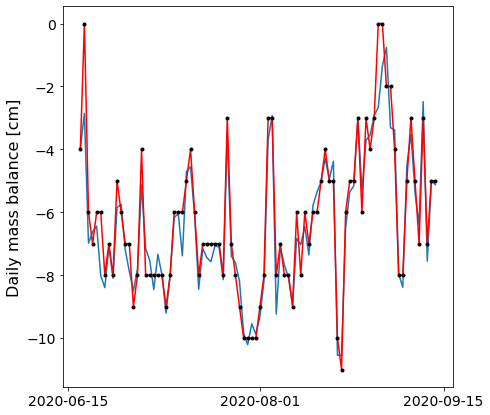

In [51]:
stations = [1001, 1008, 1003, 1007, 1006, 1002]
years = [2019, 2020]

maes = []

for year in years:
    for station in stations:
        
        if not (station==1008 and year==2020): #(station==1003 or station==1001 and year==2020):
            pass
        
        else:
        
            auto_readings = import_holfuy(station=station, year=year, format='csv_2021')
            manual_readings = import_holfuy(station=station, year=year, format='standard_point')
            manual_readings = interpolate_manual_df(manual_readings)
        
            if year==2020:
                manual_readings.date = manual_readings.date + pd.Timedelta(days=1)

            if auto_readings.date.min() <= manual_readings.date.min():
                auto_readings = auto_readings[auto_readings['date'] >= manual_readings.date.min()]
            else:
                manual_readings = manual_readings[manual_readings['date'] >= auto_readings.date.min()]

            if auto_readings.date.max() >= manual_readings.date.max():
                auto_readings = auto_readings[auto_readings['date'] <= manual_readings.date.max()]
            else:
                manual_readings = manual_readings[manual_readings['date'] <= auto_readings.date.max()]

            errors = auto_readings['dh'].values + manual_readings['mb[m.w.e]'].values/900

            fig, ax = plt.subplots(figsize=(7, 7))
            ax.plot(auto_readings.date, -auto_readings.dh*100, label='auto', color='tab:blue')
            ax.plot(manual_readings.date, manual_readings['mb[m.w.e]']/9, label='manual', color='red', marker='.', markerfacecolor='black', markeredgecolor='black')
            plt.ylabel('Daily mass balance [cm]', fontsize=16)
            
            xtime_h = np.array([dt.datetime(year,6,15), dt.datetime(year,8,1), dt.datetime(year,9,15)])
            rounded = xtime_h.astype('datetime64[D]')        
            ax.set_xticks([18428, 18475, 18520], labels=rounded)
            
            ax.tick_params(axis='both', which='major', labelsize=14)
            print(ax.get_xticks())
            
            #plt.legend(fontsize=16)
            #plt.savefig('C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\writing\\glacier_anomalies\\pictures\\auto_manual_vgl_2.png')

            mae = np.mean(abs(errors))
            maes.append(mae*100)
            print(mae*100)
print('method uncertainty', np.mean(maes), 'cm')

In [ ]:
auto_readings.date.min()
manual_readings.date.min()

In [9]:
auto_readings

,date,dh,dh_cs,dh[m.w.e],mb[m.w.e],dichte
0,2020-06-15,0.046242,0.046242,0.041618,-0.041618,0.9
1,2020-06-16,0.054159,0.100402,0.048743,-0.090361,0.9
2,2020-06-17,0.026722,0.127124,0.024050,-0.114411,0.9
3,2020-06-18,0.044598,0.171721,0.040138,-0.154549,0.9
4,2020-06-19,0.042307,0.214029,0.038076,-0.192626,0.9
...,...,...,...,...,...,...
94,2020-09-17,0.029721,6.342133,0.026749,-5.707920,0.9
95,2020-09-18,0.044205,6.386338,0.039785,-5.747704,0.9
96,2020-09-19,0.049298,6.435636,0.044368,-5.792073,0.9
97,2020-09-20,0.024879,6.460515,0.022391,-5.814464,0.9


In [10]:
manual_readings

,date,mb[m.w.e]
0,2020-06-15,-18
1,2020-06-16,-9
2,2020-06-17,-27
3,2020-06-18,-36
4,2020-06-19,-72
...,...,...
94,2020-09-17,-36
95,2020-09-18,-45
96,2020-09-19,-18
97,2020-09-20,-9
